In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import load_model
import os

2024-03-08 20:44:09.139180: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-08 20:44:09.380882: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 20:44:09.380963: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 20:44:09.421383: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-08 20:44:09.505286: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-08 20:44:09.506170: I tensorflow/core/platform/cpu_feature_guard.cc:1

# First Sperate a portion of data for testing

In [2]:
# Before running please make a folder named 'train' and in the 'train' folder create another six folder for six classes of defects
# These six folder should have 300 images each.
try:
    train_folder = "NEU/train"
    os.mkdir("NEU/test")
    test_folder = "NEU/test"
    files = os.listdir(train_folder)
    import shutil
    import numpy as np
    for f in files:
        os.mkdir(test_folder + '/'+ f)

        # 60% of the data will stay back in 'train' folder
        # 40% of the data will be moved to 'test' folder
        spilt_num=int(len(os.listdir(train_folder + '/'+ f))*0.6)

        for i in os.listdir(train_folder + '/'+ f)[spilt_num:]:
            shutil.move(train_folder + '/'+ f +'/'+ i, test_folder + '/'+ f +'/'+ i)
except:
    print("\nEverything already have in the directory. You don't need to run this cell")


Everything already have in the directory. You don't need to run this cell


## Now divide the test data into test and validation data

In [3]:
try:
    test_folder = "NEU/test"
    os.mkdir("NEU/valid")
    valid_folder = "NEU/valid"
    files = os.listdir(test_folder)
    import shutil
    import numpy as np
    for f in files:
        os.mkdir(valid_folder + '/'+ f)

        # The 40% is again split in half 20-20
        spilt_num=int(len(os.listdir(test_folder + '/'+ f))*0.5)
        
        for i in os.listdir(test_folder + '/'+ f)[spilt_num:]:
            shutil.move(test_folder + '/'+ f +'/'+ i, valid_folder + '/'+ f +'/'+ i)
except:
    print("\nEverything already have in the directory. You don't need to run this cell")


Everything already have in the directory. You don't need to run this cell


# Loading the images into image generator and also applying filters

- Rescaling
- Shear
- Zoom
- Horizontal Flip
- Rotation Range
- Width Shift Range
- Height Shift Range
- Fill Mode

In [4]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest')


test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 10 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        'NEU/train',
        target_size=(200, 200),
        batch_size=10,
        class_mode='categorical')

# Flow validation images in batches of 10 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        'NEU/valid',
        target_size=(200, 200),
        batch_size=10,
        class_mode='categorical')

Found 1080 images belonging to 6 classes.
Found 360 images belonging to 6 classes.


# Learning rate scheduling

In [5]:
initial_learning_rate = 0.001

def lr_schedule(epoch):
    # Decrease the learning rate by 10% every epoch
    return initial_learning_rate * 0.9 ** epoch 

### Defining CNN model

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (2,2), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (2,2), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (2,2), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 199, 199, 32)      416       
                                                                 
 batch_normalization (Batch  (None, 199, 199, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 98, 98, 64)        8256      
                                                                 
 batch_normalization_1 (Bat  (None, 98, 98, 64)        256       
 chNormalization)                                                
                                                        

#### Evalutaion metrics

In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print('Compiled!')

Compiled!


#### Training and validating the images

In [16]:
lr_scheduler = LearningRateScheduler(lr_schedule)
history = model.fit(train_generator,
        batch_size = 32,
        epochs=35,
        validation_data=validation_generator,
        callbacks=[lr_scheduler],
        verbose=1, shuffle=True)


model.save("defect_detection.keras")


Epoch 1/35
108/108 [==============================] - 55s 499ms/step - loss: 0.4170 - accuracy: 0.8843 - val_loss: 0.6503 - val_accuracy: 0.8139 - lr: 0.0010
Epoch 2/35
108/108 [==============================] - 53s 487ms/step - loss: 0.2914 - accuracy: 0.9009 - val_loss: 0.8010 - val_accuracy: 0.8083 - lr: 9.0000e-04
Epoch 3/35
108/108 [==============================] - 53s 487ms/step - loss: 0.2472 - accuracy: 0.9130 - val_loss: 8.0884 - val_accuracy: 0.3528 - lr: 8.1000e-04
Epoch 4/35
108/108 [==============================] - 53s 486ms/step - loss: 0.2197 - accuracy: 0.9259 - val_loss: 0.3523 - val_accuracy: 0.8528 - lr: 7.2900e-04
Epoch 5/35
108/108 [==============================] - 52s 485ms/step - loss: 0.2023 - accuracy: 0.9213 - val_loss: 2.9288 - val_accuracy: 0.5639 - lr: 6.5610e-04
Epoch 6/35
108/108 [==============================] - 52s 483ms/step - loss: 0.1485 - accuracy: 0.9435 - val_loss: 0.1658 - val_accuracy: 0.9528 - lr: 5.9049e-04
Epoch 7/35
108/108 [============

#### Plotting the result

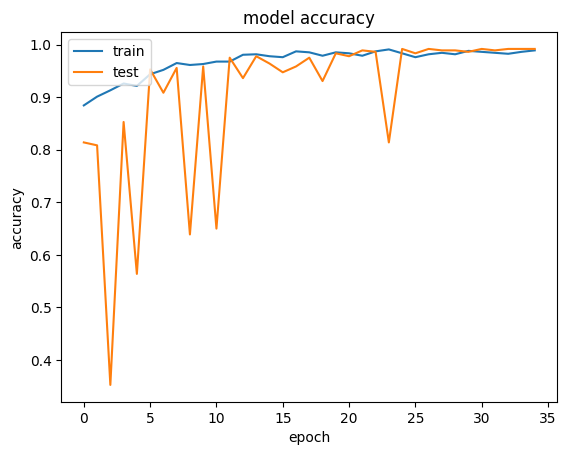

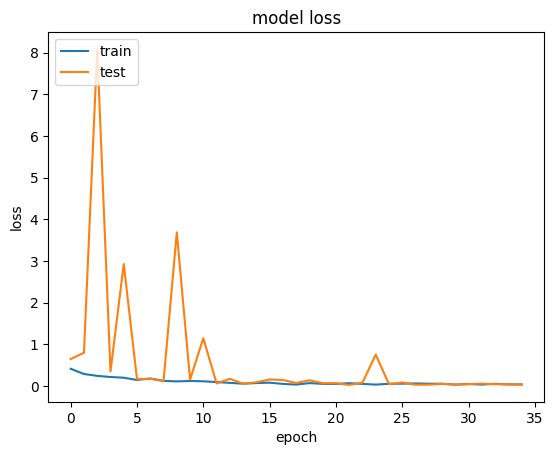

In [19]:
import matplotlib.pyplot as plt 
plt.figure(1)  
# summarize history for accuracy    
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
# summarize history for loss
plt.figure(2)
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()


# Loading the test folder for testing the model

In [10]:
# First, we are going to load the file names and their respective target labels into numpy array! 
from sklearn.datasets import load_files
from sklearn.metrics import precision_score
import numpy as np

test_dir = 'NEU/test'

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
    
x_test, y_test,target_labels = load_dataset(test_dir)

In [11]:
no_of_classes = len(np.unique(y_test))
no_of_classes

6

In [12]:
from keras import utils
y_test = utils.to_categorical(y_test, no_of_classes)


In [13]:
# We just have the file names in the x set. Let's load the images and convert them into array.
from keras.preprocessing.image import array_to_img, img_to_array, load_img

def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

Test set shape :  (360, 200, 200, 3)


In [14]:
x_test = x_test.astype('float32')/255

#### Testing the model against the test data and plotting the result

12/12 [==============================] - 3s 250ms/step
Precision = 99.46


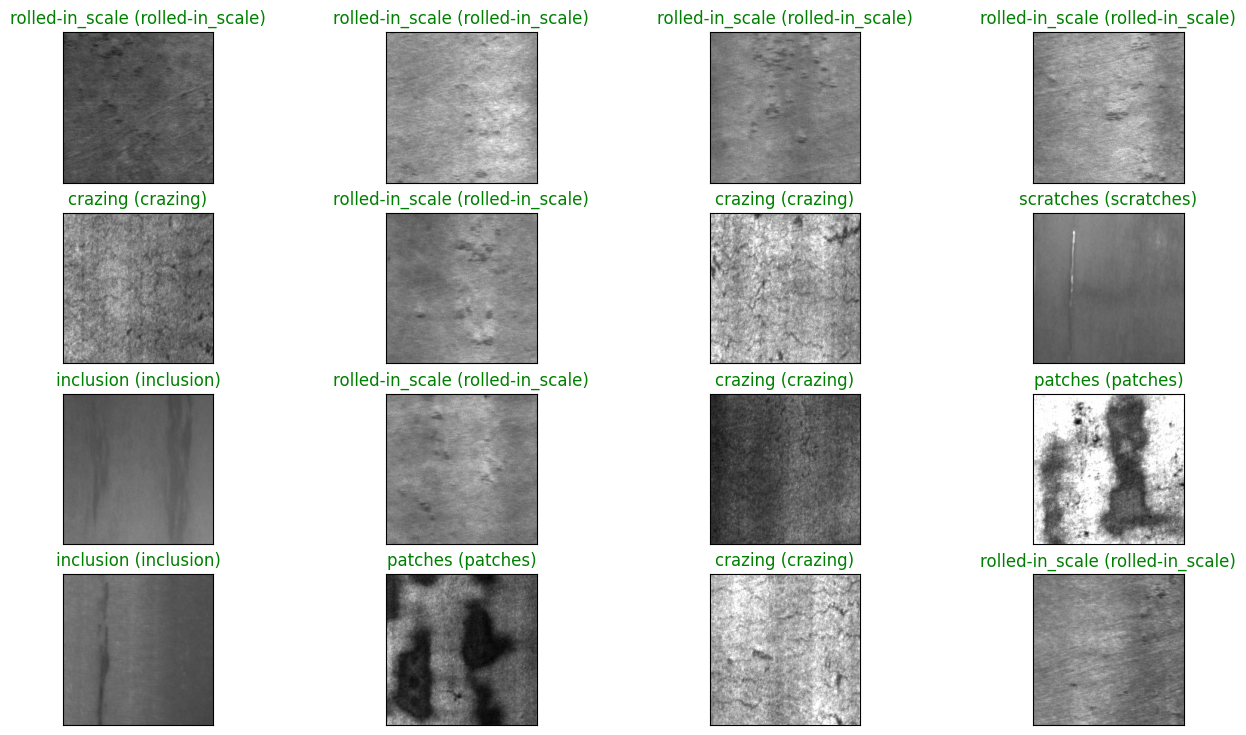

In [20]:
# Let's visualize test prediction.
model = load_model('defect_detection.keras')
y_pred = model.predict(x_test)

true_labels = np.argmax(y_test, axis=1)
predicted_labels = np.argmax(y_pred, axis=1)
precision = precision_score(true_labels, predicted_labels, average='weighted')
print("Precision = %.2f" %(precision * 100))

number_of_images = 16
rows = columns = 4

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=number_of_images, replace=False)):
    ax = fig.add_subplot(rows, columns, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))
                 